In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy as sp

### load the data

In [2]:
dataFolder = 'Data_equalWeights/'
subList = ['1cdzsxek92mz66k_2019-08-10', '9fzhnxu5uzmnbuf_2019-08-10']

In [4]:
data = pd.DataFrame()
for iSub, sub in enumerate(subList):
    dataSub = pd.read_csv(dataFolder+'preprocessed_data_'+sub+'.csv')
    data = data.append(dataSub)

### estimate betas

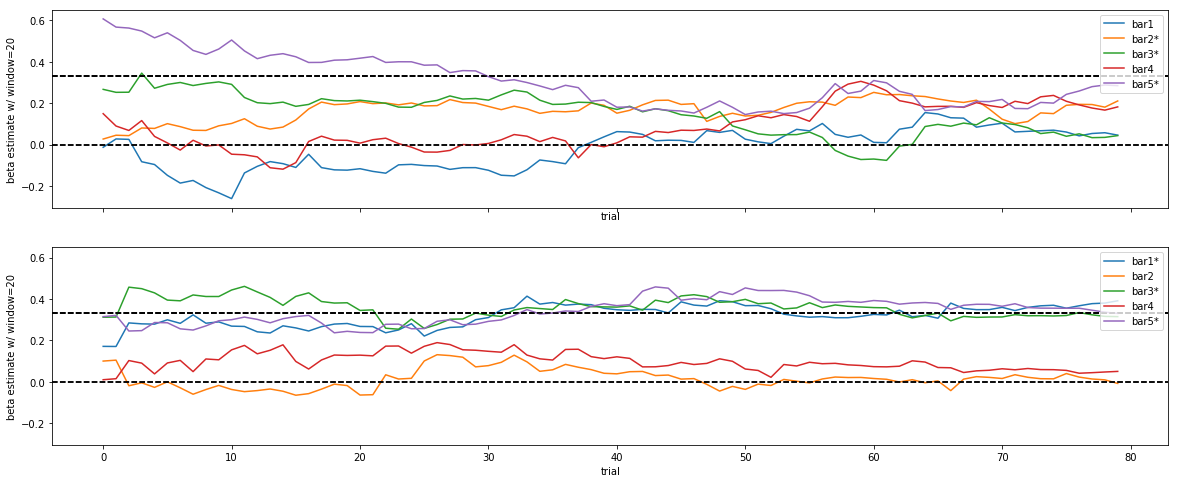

In [31]:
import statsmodels.api as sm

window = 20

fig, axes = plt.subplots(len(subList),1,figsize=(20,4*len(subList)),sharex=True,sharey=True)
cols = ['bars'+str(i+1) for i in range(5)]
coef = np.empty((len(subList), data['NTrials'].max()-window, 6))
coef[:] = np.nan
for iSub, sub in enumerate(subList):
    dataSub = data[(data['sub']==iSub+1)].copy().reset_index(drop=True)
    beta = [dataSub.loc[0,'weights'+str(iBar+1)] for iBar in range(5)]
    for i in np.arange(dataSub.loc[0,'NTrials']-window):
        dataWindow = dataSub.iloc[i:i+window]
        X = dataWindow[cols].values
        y = dataWindow['response'].values
        X = sm.add_constant(X)
        mod = sm.OLS(y, X)
        res = mod.fit()
        coef[iSub, i, -1] = res.params[0]/100
        coef[iSub, i, 0:-1] = res.params[1:]
    for iBar in range(5):
        axes[iSub].plot(coef[iSub, :, iBar], color='C'+str(iBar), label='bar'+str(iBar+1)+('*' if beta[iBar]>0 else ''))
        axes[iSub].axhline(y=beta[iBar], linestyle='--', color='k')
#     axes[iSub].set_ylim([0,1])
    axes[iSub].legend(loc=1)
    axes[iSub].set(xlabel='trial',ylabel='beta estimate w/ window='+str(window))

### absolute error

In [14]:
data['absError'] = np.abs(data['correct_response'] - data['response'])

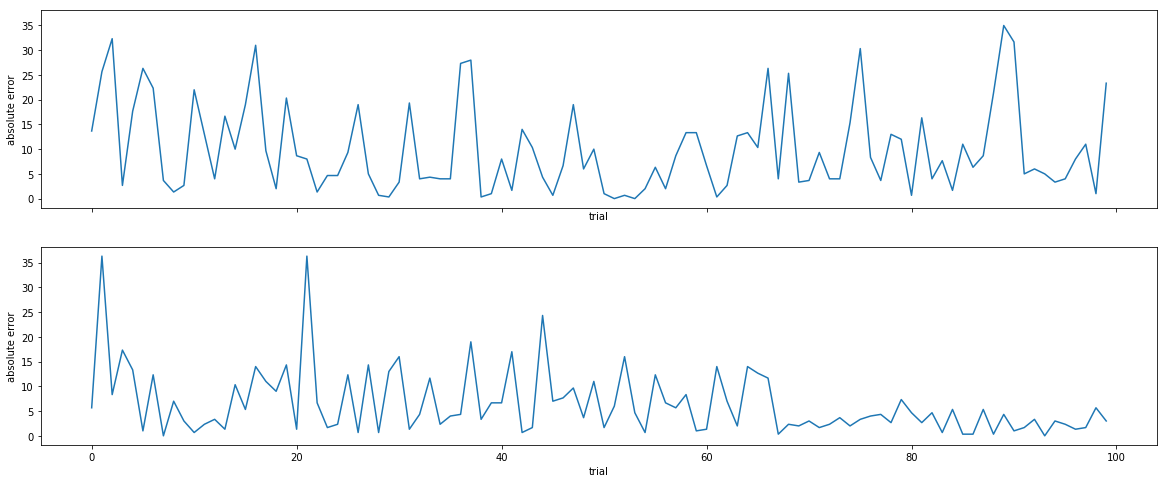

In [26]:
fig, axes = plt.subplots(len(subList),1,figsize=(20,4*len(subList)),sharex=True,sharey=True)
for iSub, sub in enumerate(subList):
    axes[iSub].plot(data.loc[data['sub']==iSub+1, 'absError'])
    axes[iSub].set(xlabel='trial',ylabel='absolute error')